In [1]:
# import required packages
from imodels import get_clean_dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from imodels.tree.rf_plus.rf_plus.rf_plus_models import RandomForestPlusRegressor
from imodels.tree.rf_plus.feature_importance.rfplus_explainer import  AloRFPlusMDI
from subgroup_detection import detect_subgroups, compute_rbo_matrix
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# get pre-cleaned compas dataset from imodels
X, _, feature_names = get_clean_dataset(43463, data_source='openml')
X = pd.DataFrame(X, columns=feature_names)

## About the Dataset
Throughout this report, we will be looking at the `insurance` dataset, which can be found on OpenML [here](https://www.openml.org/search?type=data&status=active&id=43463). Each row in this dataset represents an individual on some (unknown) health insurance plan. The task is to predict someone's medical expenses using demographic information such as age, sex, smoker status, and more. We take a peek at the data below:

In [3]:
X.head()


,age,sex,bmi,children,smoker,region,charges
0,19.0,0.0,27.900,0.0,1.0,3.0,16884.92400
1,18.0,1.0,33.770,1.0,0.0,2.0,1725.55230
2,28.0,1.0,33.000,3.0,0.0,2.0,4449.46200
3,33.0,1.0,22.705,0.0,0.0,1.0,21984.47061
4,32.0,1.0,28.880,0.0,0.0,1.0,3866.85520


In [4]:
y = X.pop('charges')
print("Dimensions of the Insurance Dataset (Covariates):", X.shape)
print("Dimensions of the Response:", y.shape)

Dimensions of the Insurance Dataset (Covariates): (1338, 6)
Dimensions of the Response: (1338,)


Before we begin analyzing our data, we first perform some simple exploratory data analysis.

In [5]:
print("---------------------------------------------")
# get correlation between age and charges
print("The Pearson Correlation Coefficient Between Age and Charges is:",
      round(X['age'].corr(y), 2))
print("---------------------------------------------")
# get the average charge by sex
print("The Average Charge for Men is:", round(y[X['sex']==1].mean(), 2))
print("The Average Charge for Women is:", round(y[X['sex']==0].mean(), 2))
print("---------------------------------------------")
# get correlation between bmi and charges
print("The Pearson Correlation Coefficient Between BMI and Charges is:",
      round(X['bmi'].corr(y), 2))
print("---------------------------------------------")
# get the correlation between children and charges
print("The Pearson Correlation Coefficient Between # of \
Children and Charges is:", round(X['children'].corr(y), 2))
print("---------------------------------------------")
# get the average charge by smoker status
print("The Average Charge for Smokers is:", round(y[X['smoker']==1].mean(), 2))
print("The Average Charge for Non-Smokers is:",
      round(y[X['smoker']==0].mean(), 2))
print("---------------------------------------------")
# get the average charge by region
print("The Average Charge for Region #1 is:",
      round(y[X['region']==0].mean(), 2))
print("The Average Charge for Region #2 is:",
      round(y[X['region']==1].mean(), 2))
print("The Average Charge for Region #3 is:",
      round(y[X['region']==2].mean(), 2))
print("The Average Charge for Region #4 is:",
      round(y[X['region']==3].mean(), 2))
print("---------------------------------------------")

---------------------------------------------
The Pearson Correlation Coefficient Between Age and Charges is: 0.3
---------------------------------------------
The Average Charge for Men is: 13956.75
The Average Charge for Women is: 12569.58
---------------------------------------------
The Pearson Correlation Coefficient Between BMI and Charges is: 0.2
---------------------------------------------
The Pearson Correlation Coefficient Between # of Children and Charges is: 0.07
---------------------------------------------
The Average Charge for Smokers is: 32050.23
The Average Charge for Non-Smokers is: 8434.27
---------------------------------------------
The Average Charge for Region #1 is: 13406.38
The Average Charge for Region #2 is: 12417.58
The Average Charge for Region #3 is: 14735.41
The Average Charge for Region #4 is: 12346.94
---------------------------------------------


It is apparent that while multiple variables might impact the medical expenses of an individual, the most eye-popping difference is the average expense difference between smokers and non-smokers.

## Modeling

Now, we split the data into training and testing datasets using a 70/30 split. We check for covariate balance in our train/test split below. We do not include `region` in this covariate balance check for the sake of brevity.

In [6]:
# split data into training and testing sets
# we won't actually use the test set here though, since 'discovery' would be
# a post-hoc analysis in real life
# proportion of training data is small so rf+ can fit without taking hours
y = np.asarray(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

In [7]:
print("---------------------------------------------")
print("Number of Observations in Training Data:", X_train.shape[0])
print("Number of Observations in Testing Data:", X_test.shape[0])
print("---------------------------------------------")
print("Average of Age in Training Data:", X_train['age'].mean())
print("Average of Age in Testing Data:", X_test['age'].mean())
print("---------------------------------------------")
print("Proportion of Men in Training Data:", X_train['sex'].mean())
print("Proportion of Men in Testing Data:", X_test['sex'].mean())
print("---------------------------------------------")
print("Proportion of Women in Training Data:", 1-X_train['sex'].mean())
print("Proportion of Women in Testing Data:", 1-X_test['sex'].mean())
print("---------------------------------------------")
print("Average of # of Children in Training Data:", X_train['children'].mean())
print("Average of # of Children in Testing Data:", X_test['children'].mean())
print("---------------------------------------------")
print("Proportion of Smokers in Training Data:", X_train['smoker'].mean())
print("Proportion of Smokers in Testing Data:", X_test['smoker'].mean())
print("---------------------------------------------")
print("Average Charge in Training Data:", y_train.mean())
print("Average Charge in Testing Data:", y_test.mean())
print("---------------------------------------------")

---------------------------------------------
Number of Observations in Training Data: 936
Number of Observations in Testing Data: 402
---------------------------------------------
Average of Age in Training Data: 39.47115384615385
Average of Age in Testing Data: 38.592039800995025
---------------------------------------------
Proportion of Men in Training Data: 0.48824786324786323
Proportion of Men in Testing Data: 0.5447761194029851
---------------------------------------------
Proportion of Women in Training Data: 0.5117521367521367
Proportion of Women in Testing Data: 0.4552238805970149
---------------------------------------------
Average of # of Children in Training Data: 1.0811965811965811
Average of # of Children in Testing Data: 1.126865671641791
---------------------------------------------
Proportion of Smokers in Training Data: 0.202991452991453
Proportion of Smokers in Testing Data: 0.208955223880597
---------------------------------------------
Average Charge in Training 

The train and test datasets seem reasonable, so we continue with our analysis. We begin by fitting a RF+ to the training data. The R^2 on the test data is reported below. The total squared error (TSE) is also reported, as we will use this to compare the 'global' model fit on all of the data to the 'local' models fit on each cluster.

In [8]:
%%capture
# fit RF+ model
rf = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus = RandomForestPlusRegressor(rf)
rf_plus.fit(X_train, y_train)

In [9]:
# compute r^2 on the test set
y_pred = rf_plus.predict(X_test)
r2 = r2_score(y_test, y_pred)
tse = np.sum((y_test - y_pred)**2)
print(f'RF+ Test Set R^2: {r2}')
print(f'RF+ Test Set TSE: {tse}')

RF+ Test Set R^2: 0.8669625283228367
RF+ Test Set TSE: 8528596608.051979


In [10]:
# get Local MDI+ feature importances
mdi_explainer = AloRFPlusMDI(rf_plus,evaluate_on='oob')
mdi, partial_preds = mdi_explainer.explain(np.asarray(X_train), y_train)
mdi_rankings = mdi_explainer.get_rankings(mdi)

## Detecting Subgroups

At this point, we are ready to cluster our data. We compute the ranking-based overlap (RBO) between each pair of points, and then use this as the distance matrix for hierarchical clustering with Ward linkage. Seven clusters are chosen due to the appearance of the heatmap below. It may be worth trying this with a range of cluster amounts and checking how it changes model performance - we could perhaps make a train/validate/test split, where we choose the number of clusters that results in the lowest total squared error in the 'local' models (or perhaps make an elbow plot, since the performance should only improve as # of clusters increases).

num_obs: 97
num_obs: 83
num_obs: 74
num_obs: 158
num_obs: 260
num_obs: 140
num_obs: 124


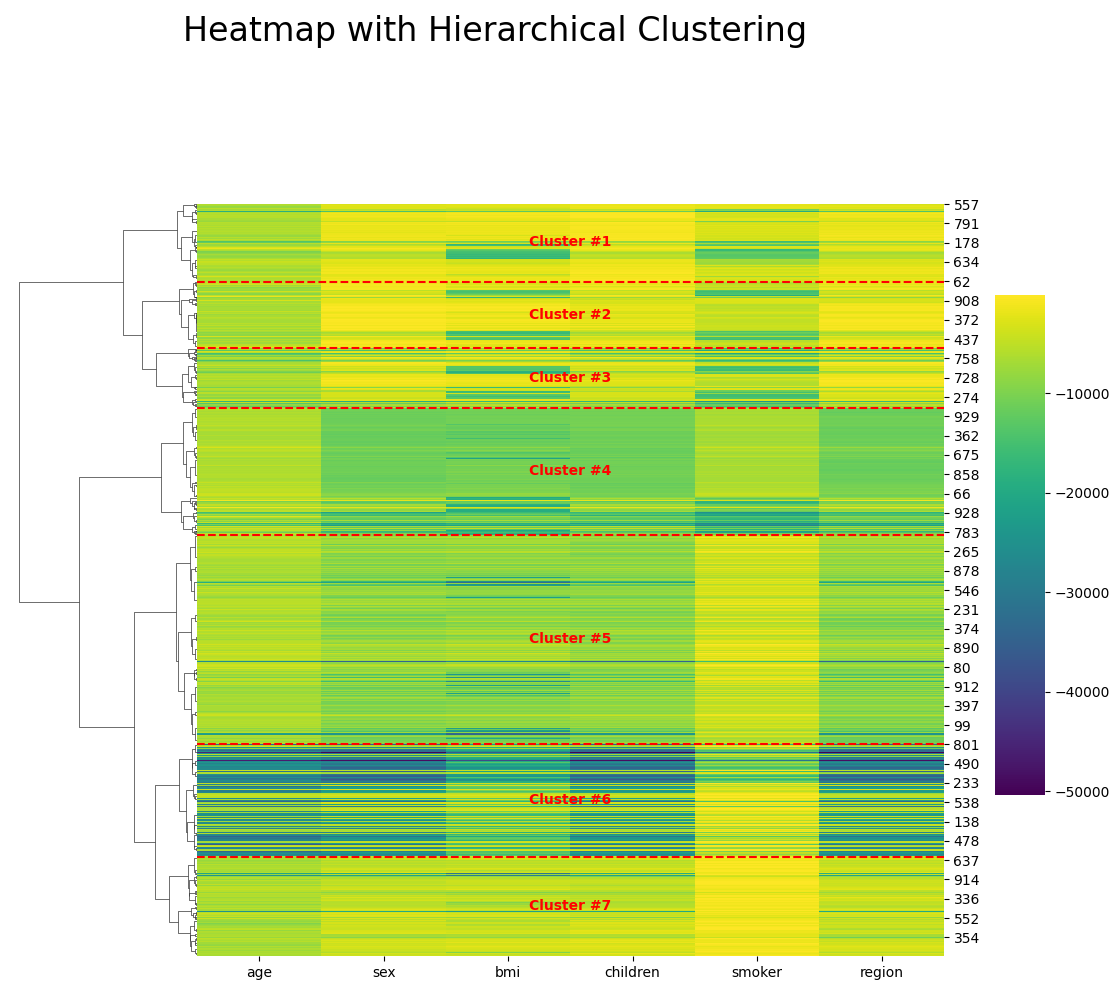

In [11]:
mdi_copy = pd.DataFrame(mdi, columns=feature_names[:-1]).copy()
num_clusters = 7
clusters = detect_subgroups(mdi_copy, mdi_rankings, num_clusters)

It is easy to see that these subgroups differ in feature importance, as shown above. However, just because they differ in feature importance does not necessarily imply that they differ in the values of those features themselves. We now check some useful summary statistics for each cluster to better understand how we have grouped the data.

In [12]:
# add clusters as column to X_train
X_train['cluster'] = clusters
print("---------------------------------------------")
# calculate average charge for each cluster
for i in range(num_clusters):
    print(f"Proportion of Data in Cluster #{i+1}:", np.sum(X_train['cluster']==i+1)/X_train.shape[0])
print("---------------------------------------------")
# get average age in each cluster
for i in range(num_clusters):
    print(f"Average Age in Cluster #{i+1}:", X_train[X_train['cluster']==i+1]['age'].mean())
print("---------------------------------------------")
# get percentage women in each cluster
for i in range(num_clusters):
    print(f"Proportion of Women in Cluster #{i+1}:", 1-X_train[X_train['cluster']==i+1]['sex'].mean())
print("---------------------------------------------")
# get percentage men in each cluster
for i in range(num_clusters):
    print(f"Proportion of Men in Cluster #{i+1}:", X_train[X_train['cluster']==i+1]['sex'].mean())
print("---------------------------------------------")
# get average bmi in each cluster
for i in range(num_clusters):
    print(f"Average BMI in Cluster #{i+1}:", X_train[X_train['cluster']==i+1]['bmi'].mean())
print("---------------------------------------------")
# get average number of children in each cluster
for i in range(num_clusters):
    print(f"Average # of Children in Cluster #{i+1}:", X_train[X_train['cluster']==i+1]['children'].mean())
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Proportion of Smokers in Cluster #{i+1}:", X_train[X_train['cluster']==i+1]['smoker'].mean())
print("---------------------------------------------")
# get proportion of smokers in each cluster
for i in range(num_clusters):
    print(f"Average Medical Expenses in Cluster #{i+1}:", y_train[X_train['cluster']==i+1].mean())
print("---------------------------------------------")

---------------------------------------------
Proportion of Data in Cluster #1: 0.10363247863247864
Proportion of Data in Cluster #2: 0.08867521367521368
Proportion of Data in Cluster #3: 0.07905982905982906
Proportion of Data in Cluster #4: 0.16880341880341881
Proportion of Data in Cluster #5: 0.2777777777777778
Proportion of Data in Cluster #6: 0.14957264957264957
Proportion of Data in Cluster #7: 0.13247863247863248
---------------------------------------------
Average Age in Cluster #1: 49.24742268041237
Average Age in Cluster #2: 49.89156626506024
Average Age in Cluster #3: 42.270270270270274
Average Age in Cluster #4: 29.018987341772153
Average Age in Cluster #5: 34.36923076923077
Average Age in Cluster #6: 40.27857142857143
Average Age in Cluster #7: 46.28225806451613
---------------------------------------------
Proportion of Women in Cluster #1: 0.5463917525773196
Proportion of Women in Cluster #2: 0.6144578313253012
Proportion of Women in Cluster #3: 0.43243243243243246
Propo

## Evaluating Cluster Performance
Now that we have a good idea of what our clustering has done, we can check if this helps improve our predictions. We will take the data in each cluster and create a train and test set, fitting a RF+ on the training data and using it to predict the test data for that cluster. We can then compute the R^2 and total squared error for each cluster's model. By summing the TSE across cluster models and comparing this to the original TSE reported above, we can get a good idea of how well these clusters improve model accuracy.

In [13]:
# split each cluster into its own set
cluster1X = X_train[X_train['cluster']==1]
cluster2X = X_train[X_train['cluster']==2]
cluster3X = X_train[X_train['cluster']==3]
cluster4X = X_train[X_train['cluster']==4]
cluster5X = X_train[X_train['cluster']==5]
cluster6X = X_train[X_train['cluster']==6]
cluster7X = X_train[X_train['cluster']==7]
cluster1y = y_train[X_train['cluster']==1]
cluster2y = y_train[X_train['cluster']==2]
cluster3y = y_train[X_train['cluster']==3]
cluster4y = y_train[X_train['cluster']==4]
cluster5y = y_train[X_train['cluster']==5]
cluster6y = y_train[X_train['cluster']==6]
cluster7y = y_train[X_train['cluster']==7]

# remove cluster column from cluster X's
cluster1X = cluster1X.drop(columns='cluster')
cluster2X = cluster2X.drop(columns='cluster')
cluster3X = cluster3X.drop(columns='cluster')
cluster4X = cluster4X.drop(columns='cluster')
cluster5X = cluster5X.drop(columns='cluster')
cluster6X = cluster6X.drop(columns='cluster')
cluster7X = cluster7X.drop(columns='cluster')

# split each cluster into train/test
cluster1_trainX, cluster1_testX, cluster1_trainy, cluster1_testy = \
    train_test_split(cluster1X, cluster1y, test_size=0.3, random_state=0)
cluster2_trainX, cluster2_testX, cluster2_trainy, cluster2_testy = \
    train_test_split(cluster2X, cluster2y, test_size=0.3, random_state=0)
cluster3_trainX, cluster3_testX, cluster3_trainy, cluster3_testy = \
    train_test_split(cluster3X, cluster3y, test_size=0.3, random_state=0)
cluster4_trainX, cluster4_testX, cluster4_trainy, cluster4_testy = \
    train_test_split(cluster4X, cluster4y, test_size=0.3, random_state=0)
cluster5_trainX, cluster5_testX, cluster5_trainy, cluster5_testy = \
    train_test_split(cluster5X, cluster5y, test_size=0.3, random_state=0)
cluster6_trainX, cluster6_testX, cluster6_trainy, cluster6_testy = \
    train_test_split(cluster6X, cluster6y, test_size=0.3, random_state=0)
cluster7_trainX, cluster7_testX, cluster7_trainy, cluster7_testy = \
    train_test_split(cluster7X, cluster7y, test_size=0.3, random_state=0)

In [14]:
%%capture
# fit RF+ on each training set, predict test
rf1 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus1 = RandomForestPlusRegressor(rf1)
rf_plus1.fit(cluster1_trainX, cluster1_trainy)

rf2 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus2 = RandomForestPlusRegressor(rf2)
rf_plus2.fit(cluster2_trainX, cluster2_trainy)

rf3 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus3 = RandomForestPlusRegressor(rf3)
rf_plus3.fit(cluster3_trainX, cluster3_trainy)

rf4 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus4 = RandomForestPlusRegressor(rf4)
rf_plus4.fit(cluster4_trainX, cluster4_trainy)

rf5 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus5 = RandomForestPlusRegressor(rf5)
rf_plus5.fit(cluster5_trainX, cluster5_trainy)

rf6 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus6 = RandomForestPlusRegressor(rf6)
rf_plus6.fit(cluster6_trainX, cluster6_trainy)

rf7 = RandomForestRegressor(n_estimators=100, random_state=0)
rf_plus7 = RandomForestPlusRegressor(rf7)
rf_plus7.fit(cluster7_trainX, cluster7_trainy)

In [15]:
# compute r^2 on the test set
print("---------------------------------------------")
y_pred = rf_plus1.predict(cluster1_testX)
r2 = r2_score(cluster1_testy, y_pred)
tse1 = np.sum((cluster1_testy - y_pred)**2)
print(f'RF+ Cluster #1 Test Set R^2: {r2}')
print(f'RF+ Cluster #1 Test Set TSE: {tse1}')
print("---------------------------------------------")
y_pred = rf_plus2.predict(cluster2_testX)
r2 = r2_score(cluster2_testy, y_pred)
tse2 = np.sum((cluster2_testy - y_pred)**2)
print(f'RF+ Cluster #2 Test Set R^2: {r2}')
print(f'RF+ Cluster #2 Test Set TSE: {tse2}')
print("---------------------------------------------")
y_pred = rf_plus3.predict(cluster3_testX)
r2 = r2_score(cluster3_testy, y_pred)
tse3 = np.sum((cluster3_testy - y_pred)**2)
print(f'RF+ Cluster #3 Test Set R^2: {r2}')
print(f'RF+ Cluster #3 Test Set TSE: {tse3}')
print("---------------------------------------------")
y_pred = rf_plus4.predict(cluster4_testX)
r2 = r2_score(cluster4_testy, y_pred)
tse4 = np.sum((cluster4_testy - y_pred)**2)
print(f'RF+ Cluster #4 Test Set R^2: {r2}')
print(f'RF+ Cluster #4 Test Set TSE: {tse4}')
print("---------------------------------------------")
y_pred = rf_plus5.predict(cluster5_testX)
r2 = r2_score(cluster5_testy, y_pred)
tse5 = np.sum((cluster5_testy - y_pred)**2)
print(f'RF+ Cluster #5 Test Set R^2: {r2}')
print(f'RF+ Cluster #5 Test Set TSE: {tse5}')
print("---------------------------------------------")
y_pred = rf_plus6.predict(cluster6_testX)
r2 = r2_score(cluster6_testy, y_pred)
tse6 = np.sum((cluster6_testy - y_pred)**2)
print(f'RF+ Cluster #6 Test Set R^2: {r2}')
print(f'RF+ Cluster #6 Test Set TSE: {tse6}')
print("---------------------------------------------")
y_pred = rf_plus7.predict(cluster7_testX)
r2 = r2_score(cluster7_testy, y_pred)
tse7 = np.sum((cluster7_testy - y_pred)**2)
print(f'RF+ Cluster #7 Test Set R^2: {r2}')
print(f'RF+ Cluster #7 Test Set TSE: {tse7}')
print("---------------------------------------------")

---------------------------------------------
RF+ Cluster #1 Test Set R^2: 0.5167922711186593
RF+ Cluster #1 Test Set TSE: 242907052.0269257
---------------------------------------------
RF+ Cluster #2 Test Set R^2: 0.8952890795407058
RF+ Cluster #2 Test Set TSE: 17546046.36145893
---------------------------------------------
RF+ Cluster #3 Test Set R^2: 0.5833946595708773
RF+ Cluster #3 Test Set TSE: 208336698.9759806
---------------------------------------------
RF+ Cluster #4 Test Set R^2: 0.9590512375368682
RF+ Cluster #4 Test Set TSE: 222032244.56791243
---------------------------------------------
RF+ Cluster #5 Test Set R^2: 0.897084283656301
RF+ Cluster #5 Test Set TSE: 355765586.3226504
---------------------------------------------
RF+ Cluster #6 Test Set R^2: 0.9914856554873769
RF+ Cluster #6 Test Set TSE: 87653925.97047529
---------------------------------------------
RF+ Cluster #7 Test Set R^2: 0.12692299915862415
RF+ Cluster #7 Test Set TSE: 561678899.0255064
------------

In [16]:
print("---------------------------------------------")
print("Difference in TSE (Global - Sum of Clusters):", round(tse - (tse1 + tse2 + tse3 + tse4 + tse5 + tse6 + tse7), 2))
print(f"Percent Improvement Over Global Model: {round(100*(tse - (tse1 + tse2 + tse3 + tse4 + tse5 + tse6 + tse7))/tse, 2)}%")
print("---------------------------------------------")

---------------------------------------------
Difference in TSE (Global - Sum of Clusters): 6832676154.8
Percent Improvement Over Global Model: 80.11%
---------------------------------------------


This is a huge improvement!